# ExprOptimization.jl

ExprOptimization.jl is a Julia package for optimizing Julia expressions.  The package implements algorithms to optimize expression trees derived from a grammar to optimize a user-defined objective function.

## Installation

To install the package:

    Pkg.add("ExprOptimization")

## Usage

To start using the package:

In [16]:
using ExprOptimization


## Example -- Approximation of π

We consider the example of finding an algebraic expression that approximates pi using only functions from a four function calculator.

First, we define a grammar:

In [17]:
grammar = @grammar begin
    R = |(1:9)
    R = R + R
    R = R - R
    R = R * R
    R = R / R
end

ExprRules.Grammar(Any[1, 2, 3, 4, 5, 6, 7, 8, 9, :(R + R), :(R - R), :(R * R), :(R / R)], Symbol[:R, :R, :R, :R, :R, :R, :R, :R, :R, :R, :R, :R, :R], Bool[true, true, true, true, true, true, true, true, true, false, false, false, false], Bool[false, false, false, false, false, false, false, false, false, false, false, false, false], Dict(:R=>[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]), Array{Symbol,1}[Symbol[], Symbol[], Symbol[], Symbol[], Symbol[], Symbol[], Symbol[], Symbol[], Symbol[], Symbol[:R, :R], Symbol[:R, :R], Symbol[:R, :R], Symbol[:R, :R]])

Next, we define the loss function by overloading the `loss` function in ExprOptimization.  The loss function returns the real-valued loss of a given expression tree.  The loss is minimized.

In [18]:
function ExprOptimization.loss(tree::RuleNode)
    value = eval(tree, grammar)
    if isinf(value) || isnan(value)
        return Inf
    end
    Δ = abs(value - π)
    return log(Δ) + length(tree) / 1e4
end

Once these are defined, we can use any of the implemented algorithms to perform the actual optimization.

### Monte Carlo

Monte Carlo draws a number of random expression trees from the grammar and returns the one with the best loss.

In [19]:
?MonteCarloParams

search: MonteCarloParams



```
MonteCarloParams
```

Parameters for Monte Carlo.

# Arguments:

  * `num_samples::Int`: number of samples
  * `max_depth::Int`: maximum depth of derivation tree


In [20]:
srand(2)
p = MonteCarloParams(500000, 15)
results_mc = optimize(p, grammar, :R)
(expr, val, err) = (results_mc.expr, eval(results_mc.expr), abs(eval(results_mc.expr)-π))

(:(4 - (4 / 9) * ((1 * ((6 - ((4 * 1) * 1) / 3) + 5)) / 5)), 3.140740740740741, 0.0008519128490522831)

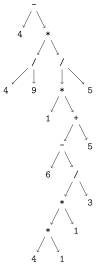

In [21]:
display(results_mc.tree, grammar)

## Genetic Programming

Genetic programming is an evolutionary algorithm for trees.

See: Koza, "Genetic Programming: On the Programming of Computers by Means of Natural Selection", MIT Press, 1992.

In [22]:
?GeneticProgramParams

search: GeneticProgramParams GeneticProgram



```
GeneticProgramParams
```

Parameters for Genetic Programming.

# Arguments

  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `p_reproduction::Float64`: probability of reproduction operator
  * `p_crossover::Float64`: probability of crossover operator
  * `p_mutation::Float64`: probability of mutation operator
  * `init_method::InitializationMethod`: initialization method
  * `select_method::SelectionMethod`: selection method


In [23]:
srand(2)
p = GeneticProgramParams(20000,25,10,0.2,0.4,0.4; select_method=GeneticProgram.TruncationSelection(100))
results_gp = optimize(p, grammar, :R)
(expr, val, err) = (results_gp.expr, eval(results_gp.expr), abs(eval(results_gp.expr)-π))

(:((1 / (6 / 5 + 7)) / 4 + (4 - 8 / 9)), 3.1415989159891597, 6.262399366629978e-6)

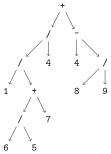

In [24]:
display(results_gp.tree, grammar)

## Cross-Entropy Method

The Cross-Entropy Method is a population-based optimization algorithm based on repeatedly estimating the probability distribution of good solutions.  This implementation uses a probabilistic grammar to represent the distributions.

See: Rubinstein, "Optimization of Computer Simulation Models with Rare Events", European Journal of Operations Research, 99, 89-112, 1197

In [25]:
?CrossEntropyParams

search: CrossEntropyParams



```
CrossEntropyParams
```

Parameters for Cross Entropy method.

# Arguments

  * `pop_size::Int`: population size
  * `iiterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `top_k::Int`: top k elite samples used in selection
  * `p_init::Float64`: initial value when fitting MLE
  * `init_method::InitializationMethod`: Initialization method


In [26]:
srand(3)
p = CrossEntropyParams(20000,25,10,5000,3000.0)
results_ce = optimize(p, grammar, :R)
(expr, val, err) = (results_ce.expr, eval(results_ce.expr), abs(eval(results_ce.expr)-π))

(:(3 + 1 / 7), 3.142857142857143, 0.0012644892673496777)

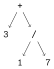

In [27]:
display(results_ce.tree, grammar)

## PIPE

Probabilistic Incremental Program Evolution (PIPE) is an expression tree optimization algorithm based on the probabilistic prototype tree (PPT) model.

See: Salustowicz and Schmidhuber, "Probabilistic Incremental Program Evolution", Evolutionary Computation, vol. 5, no. 2, pp. 123-141, 1997.

In [28]:
?PIPEParams

search: PIPEParams



```
PIPEParams
```

Parameters for Probabilistic Incremental Program Evolution. Example parameters from paper are indicated in parentheses)

# Arguments:

  * `ppt_params::PPTParams`: parameters for PPT  (e.g., [0.8, 0.2])
  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `p_elitist::Float64`: elitist update probability (e.g., 0.2)
  * `c::Float64`: learning rate multiplier (e.g., 0.1)
  * `α::Float64`: learning rate (e.g., 0.05)
  * `ϵ::Float64`: fitness constant (e.g., 1)
  * `p_mutation::Float64`: mutation probability (e.g., 0.2)
  * `β::Float64`: mutation rate (e.g., 0.6)
  * `p_threshold::Float64`: prune threshold (e.g., 0.999)
  * `max_depth::Int`: maximum depth of derivation tree


In [29]:
srand(3)
p = PIPEParams(PIPE.PPTParams(0.8),20000,25,0.2,0.1,0.05,1,0.2,0.6,0.999,10)
results_pipe = optimize(p, grammar, :R)
(expr, val, err) = (results_pipe.expr, eval(results_pipe.expr), abs(eval(results_pipe.expr)-π))

(:(4 - 6 / 7), 3.142857142857143, 0.0012644892673496777)

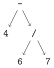

In [30]:
display(results_pipe.tree, grammar)